<a href="https://colab.research.google.com/github/thisisreallife/Medium/blob/master/Meta_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation 

In [1]:
%reset -f
import numpy as np
import scipy.stats as stats
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
import pandas as pd
from itertools import product
from multiprocessing import Pool

def unpack_args(func):
    from functools import wraps
    @wraps(func)
    def wrapper(args):
        if isinstance(args, dict):
            return func(**args)
        else:
            return func(*args)
    return wrapper

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Source:
1. [Power Analysis in Python](https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/)
2. [scipy.stats.combine_pvalues](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.combine_pvalues.html)

In [4]:
# generate data for independent ttests
results = []
for i in tqdm.tqdm(range(100)):
    data0 = stats.norm.rvs(0,1,1000)
    data1 = stats.norm.rvs(0.00,1,1000)
    results.append(stats.ttest_ind(data0, data1))
z_scores = np.array([i for i,j in results])
p_values = np.array([j for i,j in results])

  0%|          | 0/100 [00:00<?, ?it/s]

# Fisher/Stouffer methods from scratch

Fisher Mehtod

In [5]:
def FisherMethod(x):
    """
    x is a list of p_values 
    """
    test_stats = -np.log(x).sum()*2
    k  = len(x)
    res = 1-stats.chi2.cdf(test_stats, df = 2*k)
    return k, test_stats, res
FisherMethod(p_values),stats.combine_pvalues(p_values)

((100, 231.38825667970704, 0.06337804865866103),
 (231.38825667970704, 0.06337804865866103))

Stouffer's Z-score method

In [6]:
def StoufferMethod(x):
    """
    x is a list of p_values
    """
    k  = len(x)
    test_stats = - stats.norm.ppf(x).sum()/np.sqrt(k)
    res = 1-stats.norm.cdf(test_stats) # p值很小的时候, 算出来的z-score是负数, 因此这边考虑的是单侧检验.
    return k, test_stats, res

StoufferMethod(p_values), stats.combine_pvalues(p_values, method = 'stouffer')

((100, 1.6047652889072697, 0.05427273378442643),
 (1.6047652889072705, 0.054272733784426375))

# Simulation
- Definition
    - Single t-test
        - Alpha, Type I Error
        - Effect Size, MDE/Std
        - Power, 1 - Type II Error
        - Sample Size
    - meta analysis
        - Number of Studies: How many p_values we use in meta-analysis
        
- Fix single t-test's parameters, change single t-test's power and number of studies, does meta-analysis provide greater power with more p-values? 
  
  1. Fix effect_size = 0.05, alpha = 0.05, power = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], calculate sample size for single t-test. 
  2. Based on effect size, alpha, power and sample size, generate independent p-values of t-tests
  3. With increasing of number of studies, how will the power of meta-analysis change?
- If we have enough sample size, which one has larger power? Meta-analysis of M p_values or one single t-test with all samples


## Power analysis in Python

In [7]:
analysis = TTestIndPower()
# parameters for power analysis
effect = 0.05
alpha = 0.05
power = 0.5
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 3073.779


In [8]:
# parameters for power analysis
effect = 0.05
alpha = 0.05
power_list = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
sample_size_list = []
for power in power_list:
    analysis = TTestIndPower()
    result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
    sample_size_list.append(result)
sample_size_list = np.array(sample_size_list).astype(int)
sample_size_list

array([ 341,  994, 1647, 2330, 3073, 3919, 4938, 6280])

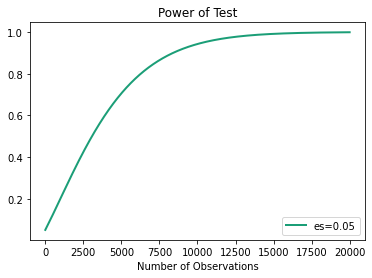

In [9]:
# parameters for power analysis
effect_sizes = np.array([0.05])
sample_sizes = np.array(range(5, 20000))
# calculate power curves from multiple power analyses
analysis = TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

## Generate p_values 

In [42]:
# decorator to unpack_args
@unpack_args
def generate_pvalues(effect_size, sample_size):
    res = []
    for i in range(100000): # 100000 indpendent p_values
        data0 = stats.norm.rvs(0,1,sample_size)
        data1 = stats.norm.rvs(0+effect_size*1,1,sample_size)
        res.append(stats.ttest_ind(data0, data1)[1])
    return effect_size, sample_size, res

In [43]:
effect_size = [0, *[0.05]*len(sample_size_list)] # The first one is A/A test, so effect_size is 0
sample_size = [sample_size_list[-1], *sample_size_list]
para_dgp = list(zip(effect_size, sample_size)) # Zip params to use in pool.imap

In [44]:
if __name__ == '__main__':
    # start 4 worker processes
    results = []
    with Pool() as pool:
        for result in tqdm.tqdm(pool.imap(generate_pvalues, para_dgp), total=para_dgp.__len__()):
            results.append(result)

  0%|          | 0/9 [00:00<?, ?it/s]

In [45]:
total_p_values = pd.DataFrame(results, columns = ['effect_size', 'sample_size', 'p_values'])

In [47]:
# Power of single ttest
total_p_values['power_theorem']  = [0.05, *[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]]
total_p_values['power_emp'] = total_p_values.p_values.apply(lambda x: (np.array(x)<0.05).mean())
total_p_values

,effect_size,sample_size,p_values,power_theorem,power_emp
0,0.00,6280,"[0.786681566651119, 0.3212448712932222, 0.2201...",0.05,0.05033
1,0.05,341,"[0.4724073000372584, 0.004422488277364576, 0.7...",0.10,0.09974
2,0.05,994,"[0.29303524439992323, 0.06929240434463659, 0.1...",0.20,0.19793
3,0.05,1647,"[0.05597853564346878, 0.9927013378084786, 0.58...",0.30,0.30018
4,0.05,2330,"[0.7971525688587416, 0.44147169836026956, 0.21...",0.40,0.39860
5,0.05,3073,"[0.006272417666491983, 0.002086895547046506, 0...",0.50,0.50148
6,0.05,3919,"[0.003579600376392399, 0.16918236420541816, 8....",0.60,0.59770
7,0.05,4938,"[0.07342987758754667, 0.2975080198564284, 0.10...",0.70,0.69921
8,0.05,6280,"[0.00325747873382007, 0.004225846929217384, 0....",0.80,0.80191


## Power of Meta-analysis 

In [48]:
# power of meta-analysis
def meta_power_cal(p_value_series, p_value_num, method):
    # cut
    m = len(p_value_series)//p_value_num
    p_value_mat = np.array(p_value_series[:m*p_value_num]).reshape(-1, p_value_num)
    # meta analysis
    res = np.apply_along_axis(lambda x: method(x)[1], axis = 1, arr = p_value_mat)
    return res

@unpack_args
def ma_power_cal_wapper(x, y):
    return x,y, (meta_power_cal(total_p_values.loc[total_p_values.power_theorem == x].p_values.item(),
                                y,
                                stats.combine_pvalues) < 0.05).mean()

power_list = total_p_values.power_theorem.tolist()
ma_num_list = np.arange(1,20)
para_zip = list(product(power_list, ma_num_list))

In [49]:
if __name__ == '__main__':
    # start 4 worker processes
    results = []
    with Pool() as pool:
        # for result in tqdm.tqdm(pool.imap_unordered(bs_log_ratio, [aa]*1000), total=1000):
        for result in tqdm.tqdm(pool.imap(ma_power_cal_wapper, para_zip), total=para_zip.__len__()):
        # for result in tqdm.tqdm(pool.imap_unordered(bs_ratio, [aa]*1000), total=1000):
        # for result in tqdm.tqdm(pool.imap_unordered(p_exact_mean, np.arange(pshape)), total=pshape):
            results.append(result)
pd.DataFrame(results, columns = ['power', 'num', 'ma_power'])

  0%|          | 0/171 [00:00<?, ?it/s]

,power,num,ma_power
0,0.05,1,0.050330
1,0.05,2,0.050740
2,0.05,3,0.052021
3,0.05,4,0.052080
4,0.05,5,0.052350
...,...,...,...
166,0.80,15,1.000000
167,0.80,16,1.000000
168,0.80,17,1.000000
169,0.80,18,1.000000


## What if we use one single t-test under sample size of all studies?

In [50]:
def whatif_single_test(num, single_size):
    analysis = TTestIndPower()
    effect = 0.05
    alpha = 0.05
    return analysis.solve_power(effect, power=None, nobs1=num*single_size, ratio=1.0, alpha=alpha)

In [51]:
output = pd.DataFrame(results, columns = ['power', 'num', 'ma_power'])
output['sample_size'] = output['power'].map(dict(zip(power_list, sample_size)))
output['all_sample_ttest_power'] = output.apply(lambda x: whatif_single_test(x.num, x.sample_size), axis = 1)
output.columns = ['single_ttest_power', 'num_of_studies', 'ma_power', 'single_ttest_sample_size', 'all_sample_ttest_power']

In [52]:
# This one is A/A Test, so effect_size is 0, power = alpha = 0.05
output.loc[output.single_ttest_power == 0.05, 'all_sample_ttest_power'] = 0.05

In [53]:
output.to_csv('ma_power_sim.csv')

## Conclusion

### A/A Test Meta-analysis

Text(0.5, 1.0, 'Type I Error of Meta-analysis is Under Control')

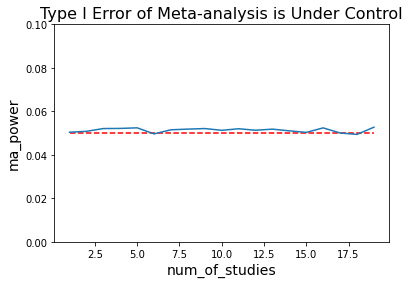

In [54]:
__ = output.loc[output.single_ttest_power == 0.05, ['single_ttest_power', 'num_of_studies', 'ma_power']]
plt.plot(__.num_of_studies, __.ma_power)
plt.hlines(y = 0.05, xmin = 1, xmax = 19, linestyles='dashed', color = 'red')
plt.ylim(0,0.1)
plt.xlabel('num_of_studies')
plt.ylabel('ma_power')
plt.xlabel('num_of_studies',fontdict={'fontsize':14})
plt.ylabel('ma_power',fontdict={'fontsize':14})
plt.title('Type I Error of Meta-analysis is Under Control',fontdict={'fontsize':16})

### More Studies Can Increase Testing Power

Text(0.5, 1.0, 'More Studies Can Increase Testing Power')

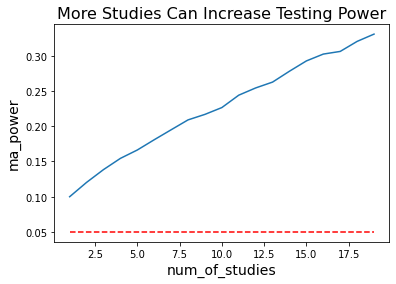

In [55]:
__ = output.loc[output.single_ttest_power == 0.1, ['single_ttest_power', 'num_of_studies', 'ma_power']]
plt.plot(__.num_of_studies, __.ma_power)
plt.hlines(y = 0.05, xmin = 1, xmax = 19, linestyles='dashed', color = 'red')
plt.xlabel('num_of_studies',fontdict={'fontsize':14})
plt.ylabel('ma_power',fontdict={'fontsize':14})
plt.title('More Studies Can Increase Testing Power',fontdict={'fontsize':16})

### But Using All Samples of MA in one Single T-test is Better 

Text(0.5, 1.0, 'More Studies Can Increase Testing Power')

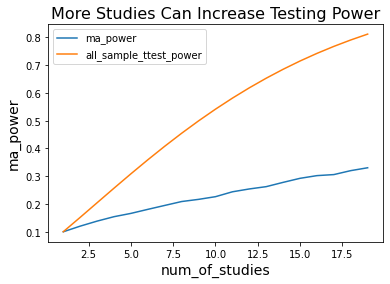

In [56]:
__ = output.loc[output.single_ttest_power == 0.1, ['all_sample_ttest_power', 'num_of_studies', 'ma_power']]
plt.plot(__.num_of_studies, __.ma_power)
plt.plot(__.num_of_studies, __.all_sample_ttest_power)
# plt.hlines(y = 0.05, xmin = 1, xmax = 19, linestyles='dashed', color = 'red')
plt.xlabel('num_of_studies',fontdict={'fontsize':14})
plt.ylabel('ma_power',fontdict={'fontsize':14})
plt.legend(labels = ['ma_power', 'all_sample_ttest_power'])
plt.title('More Studies Can Increase Testing Power',fontdict={'fontsize':16})